In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from toksearch_d3d import PtDataSignal



  The MDSplus python module version (HEAD_release_7.139.59) does not match
  the version of the installed MDSplus libraries (unknown_release_0.0.0).
  Upgrade the module using the mdsplus/python/MDSplus directory of the
  MDSplus installation or set PYTHONPATH=/usr/local/mdsplus/python.


In [23]:
def filter_lp(x, prev_y, dt, tau):
    """
    Low-pass filter function.
    
    Args:
        x: Current input value
        prev_y: Previous filtered output value
        dt: Time step
        tau: Time constant (filter strength)
    
    Returns:
        Filtered output value
    """
    return prev_y + dt / (dt + tau) * (x - prev_y)

def apply_lp_filter(data, dt, tau):
    """
    Apply low-pass filter to an array of data.
    
    Args:
        data: Input data array
        dt: Time step (or can be an array of time differences)
        tau: Time constant (controls filter strength)
    
    Returns:
        Filtered data array
    """
    filtered = np.zeros_like(data)
    filtered[0] = data[0]  # Initialize with first value
    
    for i in range(1, len(data)):
        filtered[i] = filter_lp(data[i], filtered[i-1], dt, tau)
    
    return filtered


def interp_full(psi_in, values_in, psi_out):
    """
    Full interpolation function that interpolates from (psi_in, values_in) to psi_out.
    
    Args:
        psi_in: Input psi coordinates (array)
        values_in: Input values at psi_in coordinates (array)
        psi_out: Output psi coordinates where interpolation is desired (array)
    
    Returns:
        Interpolated values at psi_out coordinates
    """
    in_size = len(psi_in)
    out_size = len(psi_out)
    out = np.zeros(out_size)
    
    # Find min and max indices
    j_min = [0, 0]
    j_max = [0, 0]
    
    # Find absolute min and max
    j_min[0] = np.argmin(psi_in)
    j_max[0] = np.argmax(psi_in)
    
    # Find second smallest and second largest
    j_min[1] = j_max[0]
    j_max[1] = j_min[0]
    
    for j in range(in_size):
        if psi_in[j] > psi_in[j_min[0]] and psi_in[j] <= psi_in[j_min[1]]:
            j_min[1] = j
        if psi_in[j] < psi_in[j_max[0]] and psi_in[j] >= psi_in[j_max[1]]:
            j_max[1] = j
    
    # Interpolate for each output point
    for i in range(out_size):
        psi_t = psi_out[i]
        j_high = j_max[0]
        j_low = j_min[0]
        
        # Find bracketing indices
        for j in range(in_size):
            if psi_in[j] > psi_t and psi_in[j] < psi_in[j_high]:
                j_high = j
            elif psi_in[j] < psi_t and psi_in[j] > psi_in[j_low]:
                j_low = j
        
        # Handle extrapolation at boundaries
        if j_high == j_max[0]:
            j_low = j_max[1]
        elif j_low == j_min[0]:
            j_high = j_min[1]
        
        # Linear interpolation
        out_high = values_in[j_high]
        out_low = values_in[j_low]
        psi_n_diff = psi_in[j_high] - psi_in[j_low]
        weight = (psi_t - psi_in[j_low]) / psi_n_diff if abs(psi_n_diff) >= 1e-5 else 0.0
        out[i] = out_low + weight * (out_high - out_low)
    
    return out


def interp_profile(values_in, out_size):
    """
    Interpolate profile from input size to output size using uniform psi grid.
    
    Args:
        values_in: Input profile values (array of length in_size)
        out_size: Desired output size (e.g., 33)
    
    Returns:
        Interpolated profile of length out_size
    """
    in_size = len(values_in)
    
    # Create uniform psi grids
    psi_in = np.linspace(0, 1, in_size)
    psi_out = np.linspace(0, 1, out_size)
    
    return interp_full(psi_in, values_in, psi_out)


def convert_profiles_101_to_33(profiles_101):
    """
    Convert profiles from 101 dimensions to 33 dimensions.
    
    Args:
        profiles_101: Array of shape (..., 101) with profiles to convert
    
    Returns:
        Array of shape (..., 33) with interpolated profiles
    """
    original_shape = profiles_101.shape
    
    # Reshape to (N, 101) where N is product of all dimensions except last
    profiles_flat = profiles_101.reshape(-1, original_shape[-1])
    
    # Interpolate each profile
    profiles_33 = np.array([interp_profile(prof, 33) for prof in profiles_flat])
    
    # Reshape back to original dimensions with 33 instead of 101
    new_shape = original_shape[:-1] + (33,)
    return profiles_33.reshape(new_shape)

def save_profile_to_template2(rot_profile=None, dens_profile=None, etemp_profile=None, pres_profile=None, filename='profiles.txt', dim = 33):
    """
    Save 4 profiles to a file in matrix format.
    
    Parameters:
    -----------
    rot_profile : array-like, optional
        Rotation profile (should be 33 dimensions). Default is array of 33 zeros.
    dens_profile : array-like, optional
        Density profile (should be 33 dimensions). Default is array of 33 zeros.
    etemp_profile : array-like, optional
        Electron temperature profile (should be 33 dimensions). Default is array of 33 zeros.
    pres_profile : array-like, optional
        Pressure profile (should be 33 dimensions). Default is array of 33 zeros.
    filename : str
        Output filename (e.g., 'my_profiles.txt')
    """
    # Set defaults if not provided
    if rot_profile is None:
        rot_profile = np.zeros(dim)
    if dens_profile is None:
        dens_profile = np.zeros(dim)
    if etemp_profile is None:
        etemp_profile = np.zeros(dim)
    if pres_profile is None:
        pres_profile = np.zeros(dim)
    # Ensure profiles are numpy arrays
    rot_profile = np.array(rot_profile)
    dens_profile = np.array(dens_profile)
    etemp_profile = np.array(etemp_profile)
    pres_profile = np.array(pres_profile)
    
    # Number of columns (assuming 33)
    n_cols = len(rot_profile)
    
    # Generate column names: 'col 0', 'col 1', ..., 'col 32'
    col_names = '|'.join([f'col {i}' for i in range(n_cols)])
    
    # Row names
    row_names = '|'.join(['rot', 'ne', 'te', 'pres'])
    
    # Write to file
    with open(filename, 'w') as f:
        # Write column name header
        f.write(f'COL_NAMES=|{col_names}\n')
        
        # Write row names header
        f.write(f'ROW_NAMES=|{row_names}\n')
        
        # Write each profile as a row
        profiles = [rot_profile, dens_profile, etemp_profile, pres_profile]
        for profile in profiles:
            row_values = ''.join([f'{value:12.2f}' for value in profile])
            f.write(f'{row_values}\n')
    
    print(f"Profiles saved to {filename}")

## ACTUAL RUN FROM HERE

In [19]:
## ENTER SHOT INFO

shot=203018
x=PtDataSignal('CKXOUT').fetch(shot)

Environment variable TOKSEARCH_INDEX_DIR not set.
Environment variable TOKSEARCH_INDEX_DIR not set.
Environment variable TOKSEARCH_INDEX_DIR not set.
Environment variable TOKSEARCH_INDEX_DIR not set.


In [24]:
times = x['times']
data = x['data']

NYMODEL = 2
NYOUT_PTS = 101
NYPROF = 7

prof_data = data.reshape((-1, NYMODEL, NYOUT_PTS, NYPROF))

dens_profiles = prof_data[:, 1, :, 3]  # 3-- for density || 6 for rotation
rot_profiles = prof_data[:, 1, :, 6]
q_profiles = prof_data[:, 1, :, 2]
pres_profiles = prof_data[:, 1, :, 0]
etemp_profiles = prof_data[:, 1, :, 4]

prof_data = {
    'ne': dens_profiles,
    'rot': rot_profiles,
    'q': q_profiles,
    'pres': pres_profiles,
    'te': etemp_profiles,
}

In [25]:
## Set PROFILE TYPE
prof_type = 'rot'
profiles = prof_data[prof_type]

Text(0.5, 1.0, 'rot profile at spatial index 30')

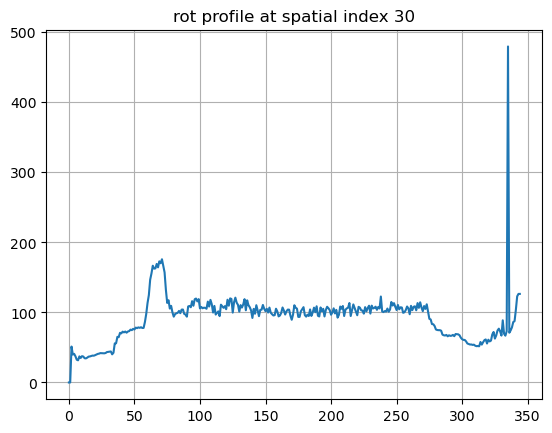

In [26]:

spatial_index = 30
plt.plot(profiles[:, spatial_index])
plt.grid(True)
plt.title(f'{prof_type} profile at spatial index {spatial_index}')

Text(0.5, 1.0, 'rot profiles at selected time indices')

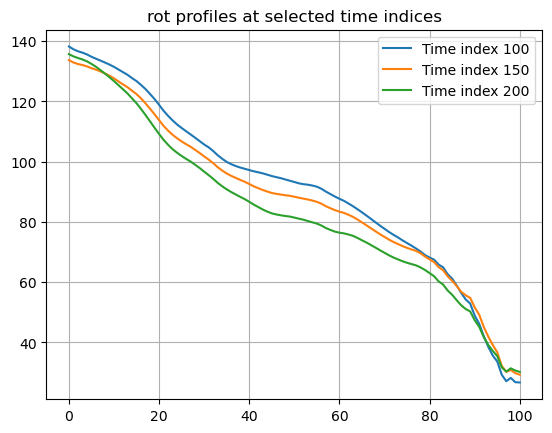

In [27]:
## ENTER TIME INDICES to plot

time_indices = [100,150,200]
for time_index in time_indices:
    plt.plot(profiles[time_index, :], label = f'Time index {time_index}')
plt.legend()
plt.grid(True)
plt.title(f'{prof_type} profiles at selected time indices')

In [30]:
## save values
SELECT_TIME_INDEX = 150
FILENAME = f's{shot}_idx{SELECT_TIME_INDEX}.txt'

## save all at the current time index
save_prof = {}
keys = prof_data.keys() - {'q'}

for key in keys:
    prof = prof_data[key]
    selected_prof = prof[SELECT_TIME_INDEX, :]
    prof33 = convert_profiles_101_to_33(selected_prof)
    prof33_interp = interp_profile(selected_prof, 33)
    save_prof[key] = prof33_interp


save_profile_to_template2(rot_profile=save_prof.get('rot'),
                            dens_profile=save_prof.get('ne'),
                            etemp_profile=save_prof.get('te'),
                            pres_profile=save_prof.get('pres'),
                            filename=FILENAME, dim = 33)

# print(f'Saved profiles to {FILENAME}')


Profiles saved to s203018_idx150.txt


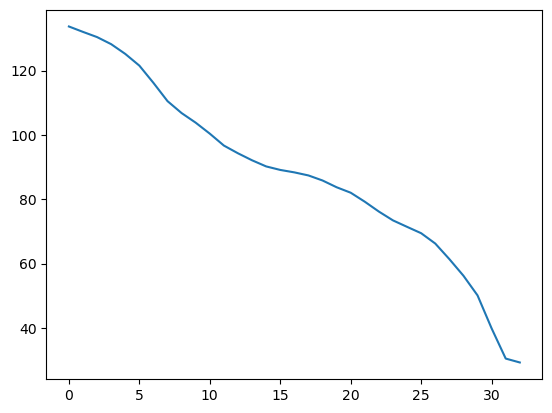

In [ ]:
## just a check plot

plt.plot(save_prof['rot'])